## XGBoost Regression Model

**Description:**

This notebook trains XGBoost gradient boosting regressors to forecast pollutant concentrations at horizons t+1, t+6, t+12, and t+24 hours for all five pollutants: CO(GT), NMHC(GT), C6H6(GT), NOx(GT), and NO2(GT). It compares against a naive baseline that predicts y(t+h) using y(t).

**Data split:** Chronological — train on 2004, test on 2005.

**Features:** Uses the team's engineered feature set from `dataset/AirQualityUCI_features.csv` (created by the shared pipeline in `src/data/feature_engineering.py`), including lag features, rolling statistics, temporal encodings, and meteorological variables.


## Setup Instructions

**Before running this notebook:**

1. Install dependencies (in home directory):
   ```bash
   pip install -r requirements.txt
   ```

2. Run all cells sequentially (Cell → Run All)

**Outputs:**
- `xgb_regression_results.csv` - RMSE metrics for all models
- `xgb_regression_predictions.png` - Time series visualizations
- `xgb_regression_residuals.png` - Residual analysis plots

In [1]:
# Import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Set random seed 
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set plotting style
sns.set_style("whitegrid")
sns.set_context("notebook")
plt.rcParams['figure.figsize'] = (12, 5)

# verify packages
print(f"  XGBoost version: {xgb.__version__}")
print(f"  NumPy version: {np.__version__}")
print(f"  Pandas version: {pd.__version__}")

  XGBoost version: 3.1.1
  NumPy version: 2.2.6
  Pandas version: 2.3.1


In [3]:
# Load engineered features
features_path = os.path.join('..','..', '..', 'dataset', 'AirQualityUCI_features.csv')
print(f"Loading: {os.path.abspath(features_path)}")

df = pd.read_csv(features_path)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime').reset_index(drop=True)

print(f"Data loaded successfully")
print(f"  Total rows: {len(df):,}")
print(f"  Total columns: {len(df.columns)}")
print(f"  Date range: {df['DateTime'].min()} to {df['DateTime'].max()}")
print(f"  Years: {sorted(df['DateTime'].dt.year.unique())}")

df.head()

Loading: c:\Users\jerry\OneDrive\Desktop\9417_Group_Project\dataset\AirQualityUCI_features.csv
Data loaded successfully
  Total rows: 9,309
  Total columns: 103
  Date range: 2004-03-11 18:00:00 to 2005-04-03 14:00:00
  Years: [np.int32(2004), np.int32(2005)]


,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,NOx(GT)_t+12,NOx(GT)_t+24,NO2(GT)_t+1,NO2(GT)_t+6,NO2(GT)_t+12,NO2(GT)_t+24,CO_bin_t+1,CO_bin_t+6,CO_bin_t+12,CO_bin_t+24
0,2004-03-11 18:00:00,0.398305,0.670495,0.325472,0.511196,0.188896,0.202033,0.440828,0.688849,0.516073,...,0.036561,0.138118,0.502959,0.281065,0.204142,0.434911,low,low,low,low
1,2004-03-11 19:00:00,0.576271,0.810481,0.429245,0.603495,0.257955,0.160949,0.502959,0.801259,0.644222,...,0.072444,0.135410,0.482249,0.319527,0.301775,0.423077,low,low,low,low
2,2004-03-11 20:00:00,0.508475,0.712850,0.375786,0.557619,0.236290,0.178314,0.482249,0.737410,0.622502,...,0.206500,0.228842,0.396450,0.263314,0.411243,0.497041,low,low,low,low
3,2004-03-11 21:00:00,0.322034,0.478105,0.199686,0.378482,0.161137,0.268954,0.396450,0.519784,0.462207,...,0.165877,0.184157,0.245562,0.176036,0.383136,0.434911,low,low,low,low
4,2004-03-11 22:00:00,0.118644,0.228284,0.072327,0.199891,0.062288,0.424820,0.245562,0.351619,0.260643,...,0.125254,0.169939,0.150888,0.088757,0.355030,0.405325,low,low,low,low


In [4]:
# Train on 2004, Test on 2005
df['year'] = df['DateTime'].dt.year
train_2004 = df[df['year'] == 2004].copy()
test_2005 = df[df['year'] == 2005].copy()

# Create validation set from last 20% of 2004 data
val_split_idx = int(len(train_2004) * 0.8)
train_data = train_2004.iloc[:val_split_idx].copy()
val_data = train_2004.iloc[val_split_idx:].copy()

print("Temporal split complete")
print(f"  Training set (2004 - 80%):   {len(train_data):,} rows | {train_data['DateTime'].min()} to {train_data['DateTime'].max()}")
print(f"  Validation set (2004 - 20%): {len(val_data):,} rows | {val_data['DateTime'].min()} to {val_data['DateTime'].max()}")
print(f"  Test set (2005):             {len(test_2005):,} rows | {test_2005['DateTime'].min()} to {test_2005['DateTime'].max()}")

# Define pollutants and horizons
POLLUTANTS = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)'] # excluding NMHC
HORIZONS = [1, 6, 12, 24]

print(f"\nModel configuration")
print(f"  Pollutants: {POLLUTANTS}")
print(f"  Forecast horizons: {HORIZONS} hours")
print(f"  Total models: {len(POLLUTANTS) * len(HORIZONS)} regression + {len(HORIZONS)} classification")

Temporal split complete
  Training set (2004 - 80%):   5,668 rows | 2004-03-11 18:00:00 to 2004-11-02 21:00:00
  Validation set (2004 - 20%): 1,418 rows | 2004-11-02 22:00:00 to 2004-12-31 23:00:00
  Test set (2005):             2,223 rows | 2005-01-01 00:00:00 to 2005-04-03 14:00:00

Model configuration
  Pollutants: ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
  Forecast horizons: [1, 6, 12, 24] hours
  Total models: 16 regression + 4 classification


In [5]:
# Prepare feature columns (exclude DateTime, year, and all target columns)
all_cols = df.columns.tolist()
exclude_cols = ['DateTime', 'year']

# Exclude all target columns (regression targets and classification bins)
for pollutant in POLLUTANTS:
    for h in HORIZONS:
        exclude_cols.append(f"{pollutant}_t+{h}")

for h in HORIZONS:
    exclude_cols.append(f"CO_bin_t+{h}")

# Feature columns = everything else
feature_cols = [col for col in all_cols if col not in exclude_cols]

print(f"  Total features: {len(feature_cols)}")
print(f"  Excluded columns: {len(exclude_cols)} (targets + metadata)")
print(f"\n  Sample features: {feature_cols[:10]}")
print(f"  ...")
print(f"  {feature_cols[-5:]}")

  Total features: 82
  Excluded columns: 22 (targets + metadata)

  Sample features: ['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T']
  ...
  ['NOx_NO2_ratio', 'C6H6_CO_ratio', 'PT08.S1(CO)_minus_CO(GT)', 'PT08.S3(NOx)_minus_NOx(GT)', 'PT08.S4(NO2)_minus_NO2(GT)']


In [6]:
# XGBoost Regression
regression_results = []


print("Training XGBoost")

for pollutant in POLLUTANTS:
    print(f"POLLUTANT: {pollutant}")

    
    for horizon in HORIZONS:
        target_col = f"{pollutant}_t+{horizon}"
        
        # Skip if target doesn't exist
        if target_col not in df.columns:
            print(f"Skipping {target_col} - column not found")
            continue
        
        print(f"\n  Training horizon t+{horizon}h...")
        
        # Prepare data
        X_train = train_data[feature_cols]
        y_train = train_data[target_col]
        X_val = val_data[feature_cols]
        y_val = val_data[target_col]
        X_test = test_2005[feature_cols]
        y_test = test_2005[target_col]
        
        # Train XGBoost model
        model = xgb.XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            tree_method='hist'
        )
        
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        
        # Predictions
        y_pred_xgb = model.predict(X_test)
        
        # XGBoost RMSE
        rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
        
        # Naive baseline: use current value to predict future
        # For t+h, naive prediction is the value at time t
        y_naive = test_2005[pollutant].values
        rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))
        
        # Calculate improvement
        improvement_pct = ((rmse_naive - rmse_xgb) / rmse_naive) * 100 if rmse_naive > 0 else 0
        
        # Store results
        regression_results.append({
            'Pollutant': pollutant,
            'Horizon': f't+{horizon}h',
            'RMSE_XGBoost': rmse_xgb,
            'RMSE_Naive': rmse_naive,
            'Improvement_%': improvement_pct,
            'n_estimators': model.n_estimators
        })
        
        print(f" RMSE (XGBoost): {rmse_xgb:.6f}")
        print(f" RMSE (Naive):   {rmse_naive:.6f}")
        print(f" Improvement:    {improvement_pct:.2f}%")


print("\n Training complete")


Training XGBoost
POLLUTANT: CO(GT)

  Training horizon t+1h...
 RMSE (XGBoost): 0.053981
 RMSE (Naive):   0.065505
 Improvement:    17.59%

  Training horizon t+6h...
 RMSE (XGBoost): 0.096870
 RMSE (Naive):   0.149923
 Improvement:    35.39%

  Training horizon t+12h...
 RMSE (XGBoost): 0.112561
 RMSE (Naive):   0.150044
 Improvement:    24.98%

  Training horizon t+24h...
 RMSE (XGBoost): 0.109738
 RMSE (Naive):   0.106128
 Improvement:    -3.40%
POLLUTANT: C6H6(GT)

  Training horizon t+1h...
 RMSE (XGBoost): 0.048209
 RMSE (Naive):   0.056496
 Improvement:    14.67%

  Training horizon t+6h...
 RMSE (XGBoost): 0.088411
 RMSE (Naive):   0.127404
 Improvement:    30.61%

  Training horizon t+12h...
 RMSE (XGBoost): 0.114358
 RMSE (Naive):   0.131818
 Improvement:    13.25%

  Training horizon t+24h...
 RMSE (XGBoost): 0.116750
 RMSE (Naive):   0.092482
 Improvement:    -26.24%
POLLUTANT: NOx(GT)

  Training horizon t+1h...
 RMSE (XGBoost): 0.082736
 RMSE (Naive):   0.073657
 Improvem

In [7]:
# Display regression results summary
results_df = pd.DataFrame(regression_results)
results_df = results_df.sort_values(['Pollutant', 'Horizon'])

print("Regression results summary")
print(results_df.to_string(index=False))

# Highlight best performing models
print("\nBest models by improvement over baseline")
top_models = results_df.nlargest(5, 'Improvement_%')
print(top_models[['Pollutant', 'Horizon', 'RMSE_XGBoost', 'Improvement_%']].to_string(index=False))

# Save results to CSV 
results_path = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '.', 'results_xgboost.csv')
results_df.to_csv(results_path, index=False)
print(f"\nResults saved to: {os.path.abspath(results_path)}")

Regression results summary
Pollutant Horizon  RMSE_XGBoost  RMSE_Naive  Improvement_%  n_estimators
 C6H6(GT)   t+12h      0.114358    0.131818      13.245020           300
 C6H6(GT)    t+1h      0.048209    0.056496      14.667945           300
 C6H6(GT)   t+24h      0.116750    0.092482     -26.240452           300
 C6H6(GT)    t+6h      0.088411    0.127404      30.605609           300
   CO(GT)   t+12h      0.112561    0.150044      24.981608           300
   CO(GT)    t+1h      0.053981    0.065505      17.592925           300
   CO(GT)   t+24h      0.109738    0.106128      -3.402030           300
   CO(GT)    t+6h      0.096870    0.149923      35.387182           300
  NO2(GT)   t+12h      0.131063    0.203011      35.440397           300
  NO2(GT)    t+1h      0.095851    0.073766     -29.940110           300
  NO2(GT)   t+24h      0.136021    0.130998      -3.834407           300
  NO2(GT)    t+6h      0.131990    0.202985      34.975554           300
  NOx(GT)   t+12h      0

Predictions plot saved to: c:\Users\jerry\OneDrive\Desktop\9417_Group_Project\src\regression\XGBoost\plots_xgboost_predictions.png


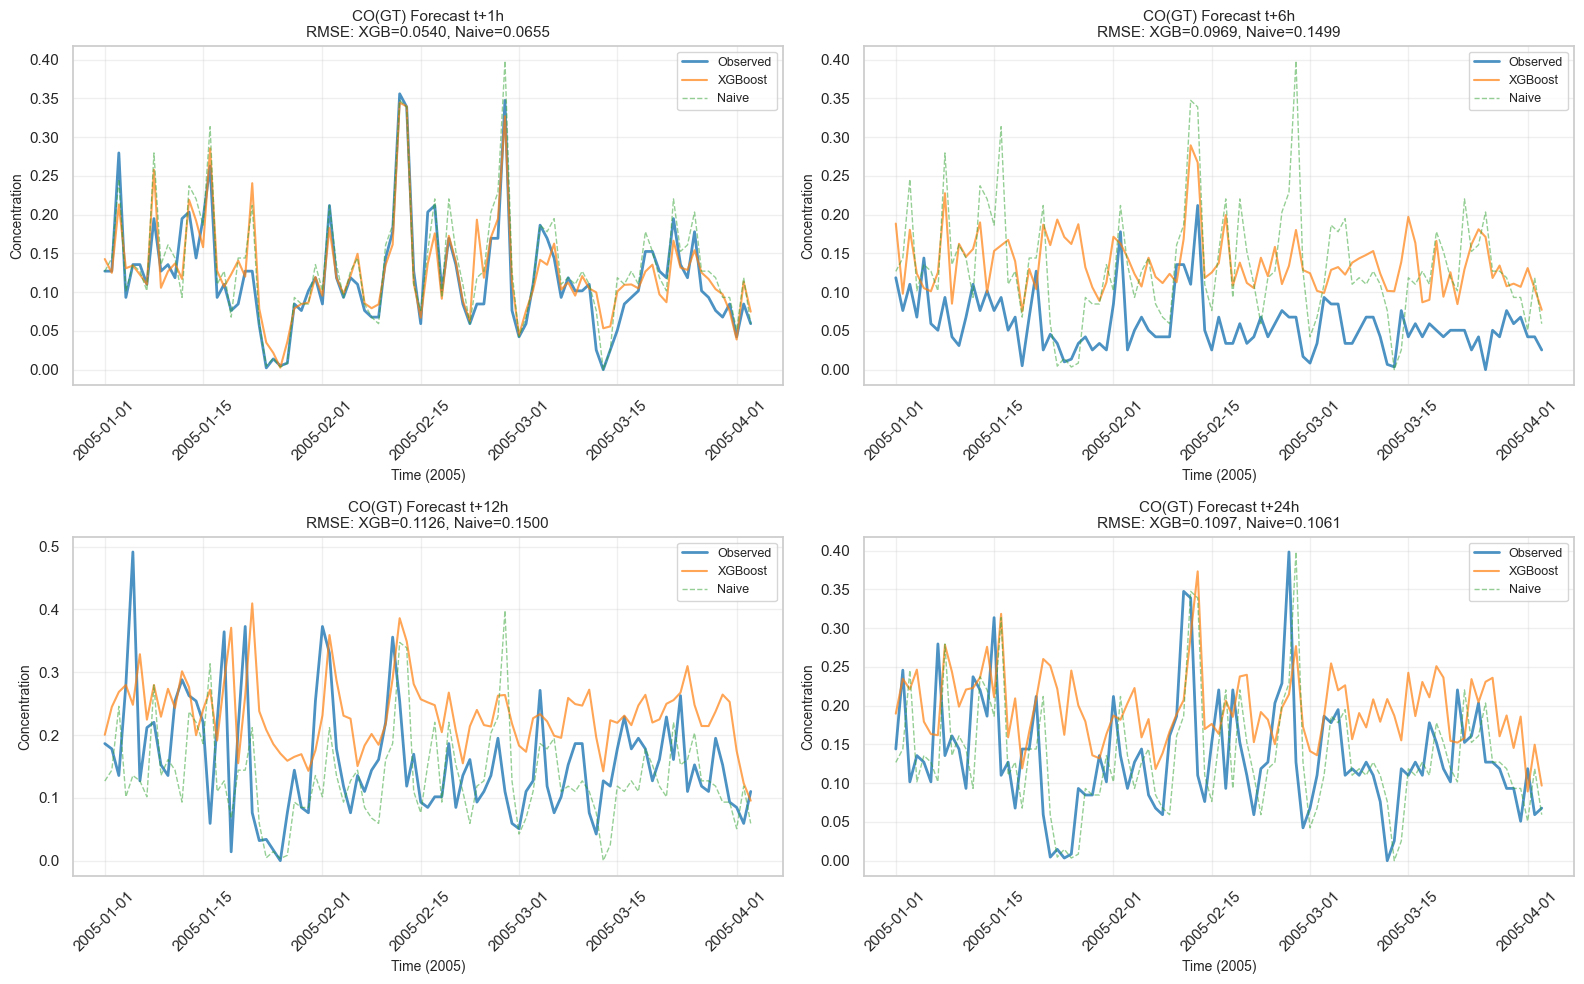

In [8]:
# Visualize predictions vs observed for selected models (one example per horizon)
selected_pollutant = 'CO(GT)'  # Focus on CO for visualization

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, horizon in enumerate(HORIZONS):
    target_col = f"{selected_pollutant}_t+{horizon}"
    
    # Train a model for visualization
    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    X_val = val_data[feature_cols]
    y_val = val_data[target_col]
    X_test = test_2005[feature_cols]
    y_test = test_2005[target_col]
    
    model = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
        objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='hist'
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred = model.predict(X_test)
    y_naive = test_2005[selected_pollutant].values
    
    # Plot predictions vs observed over time
    ax = axes[idx]
    time_subset = test_2005['DateTime'].iloc[::24]  # Sample every 24 hours for clarity
    y_test_subset = y_test.iloc[::24]
    y_pred_subset = y_pred[::24]
    y_naive_subset = y_naive[::24]
    
    ax.plot(time_subset, y_test_subset, label='Observed', linewidth=2, alpha=0.8)
    ax.plot(time_subset, y_pred_subset, label='XGBoost', linewidth=1.5, alpha=0.7)
    ax.plot(time_subset, y_naive_subset, label='Naive', linewidth=1, alpha=0.5, linestyle='--')
    
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_naive = np.sqrt(mean_squared_error(y_test, y_naive))
    
    ax.set_title(f'{selected_pollutant} Forecast t+{horizon}h\nRMSE: XGB={rmse_xgb:.4f}, Naive={rmse_naive:.4f}', fontsize=11)
    ax.set_xlabel('Time (2005)', fontsize=10)
    ax.set_ylabel('Concentration', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save to local directory
plot_path = 'plots_xgboost_predictions.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"Predictions plot saved to: {os.path.abspath(plot_path)}")

plt.show()

Residuals plot saved to: c:\Users\jerry\OneDrive\Desktop\9417_Group_Project\src\regression\XGBoost\plots_xgboost_residuals.png


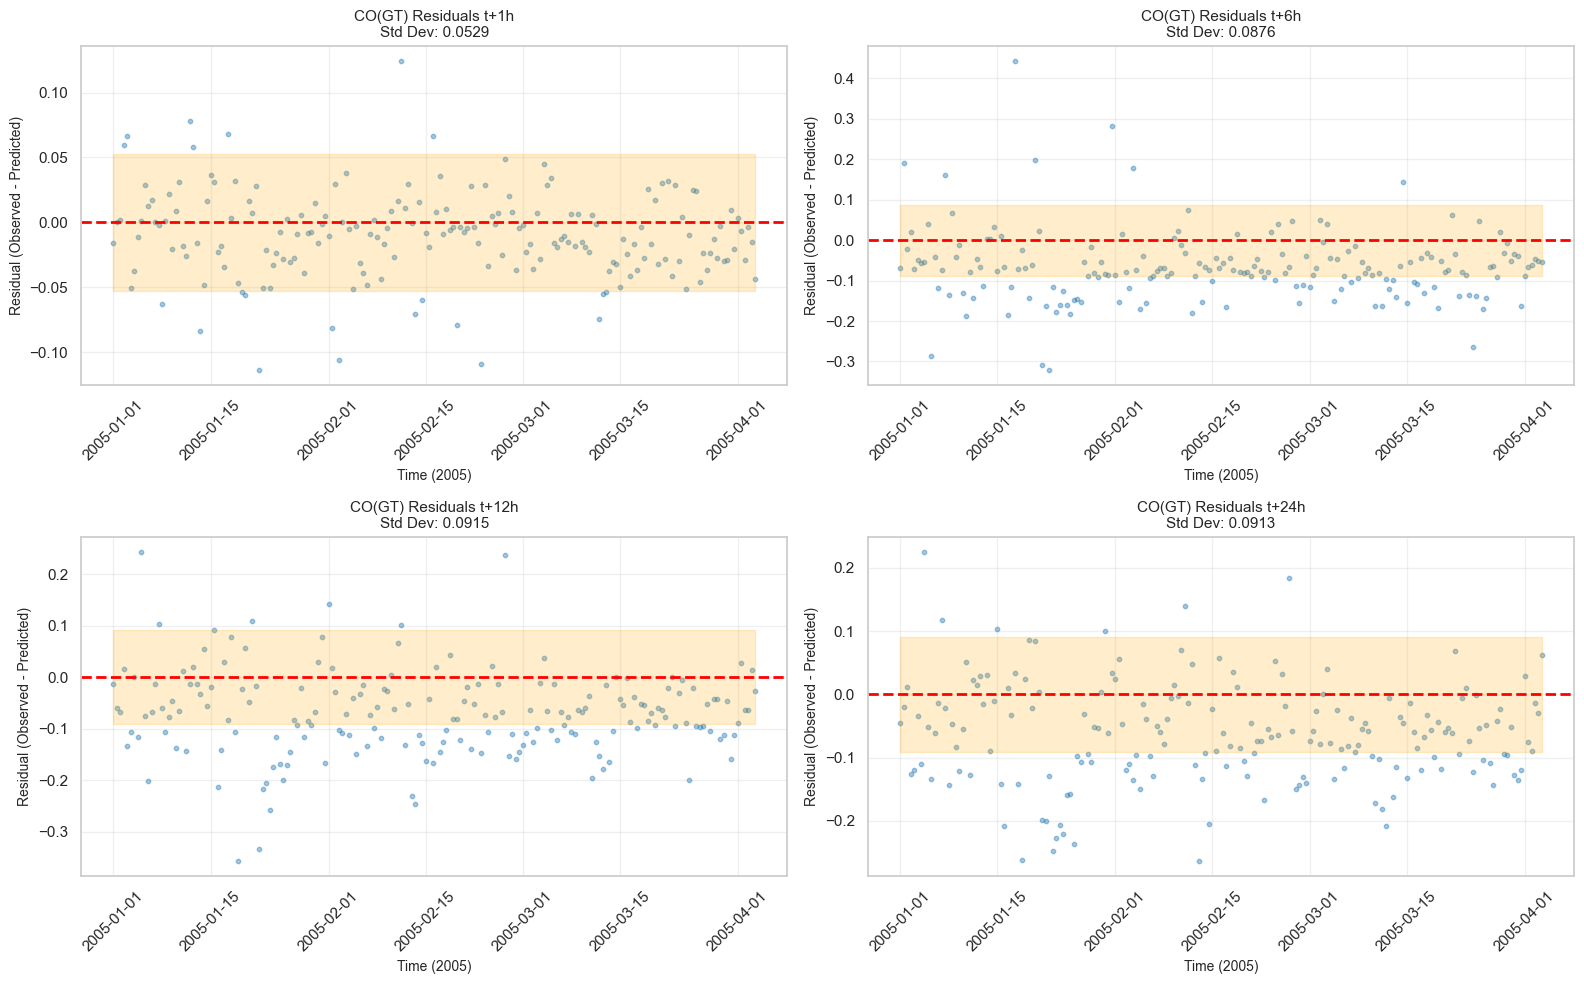

In [9]:
# Residual analysis for CO(GT) across all horizons
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, horizon in enumerate(HORIZONS):
    target_col = f"{selected_pollutant}_t+{horizon}"
    
    # Train model
    X_train = train_data[feature_cols]
    y_train = train_data[target_col]
    X_val = val_data[feature_cols]
    y_val = val_data[target_col]
    X_test = test_2005[feature_cols]
    y_test = test_2005[target_col]
    
    model = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
        objective='reg:squarederror', random_state=42, n_jobs=-1, tree_method='hist'
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    
    # Plot residuals over time
    ax = axes[idx]
    time_subset = test_2005['DateTime'].iloc[::12]  # Sample every 12 hours
    residuals_subset = residuals.iloc[::12]
    
    ax.scatter(time_subset, residuals_subset, alpha=0.4, s=10)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.fill_between(time_subset, -residuals.std(), residuals.std(), alpha=0.2, color='orange')
    
    ax.set_title(f'{selected_pollutant} Residuals t+{horizon}h\nStd Dev: {residuals.std():.4f}', fontsize=11)
    ax.set_xlabel('Time (2005)', fontsize=10)
    ax.set_ylabel('Residual (Observed - Predicted)', fontsize=10)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save to local directory
residual_path = 'plots_xgboost_residuals.png'
plt.savefig(residual_path, dpi=150, bbox_inches='tight')
print(f"Residuals plot saved to: {os.path.abspath(residual_path)}")


plt.show()